In [1]:
pip install pandas scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 12.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

In [3]:
# Veri setini oku
data = pd.read_csv('/kaggle/input/pima-india/diabetes.csv')

In [4]:
# Özellik mühendisliği: Yeni özellikler ekleyelim
data['Glucose_BMI_Ratio'] = data['Glucose'] / (data['BMI'] + 0.001)
data['Age_BMI_Product'] = data['Age'] * data['BMI'] / 100
data['Glucose_BP_Product'] = data['Glucose'] * data['BloodPressure'] / 100
data['Insulin_Glucose_Index'] = (data['Insulin'] * data['Glucose']) / 405
data['BMI_Pregnancies_Product'] = data['BMI'] * (data['Pregnancies'] + 1) / 10
data['DiabetesPedigreeFunction_Age'] = data['DiabetesPedigreeFunction'] * data['Age'] / 10

Bu özellik mühendisliği adımları, veri setindeki bazı özelliklerin (özellikle Glucose, BMI, Age, vb.) kombinasyonlarıyla yeni özellikler yaratmayı amaçlar. Bu tür yeni özellikler, modelin daha iyi performans göstermesine yardımcı olabilir çünkü bu ilişkiler, veri setindeki temel desenleri daha iyi yakalayabilir. Şimdi her bir yeni özelliği açıklayalım:

1. **`Glucose_BMI_Ratio`**:
   ```python
   data['Glucose_BMI_Ratio'] = data['Glucose'] / (data['BMI'] + 0.001)
   ```
   - **Açıklama**: Bu özellik, **Glucose** ve **BMI** arasındaki oranı hesaplar. **BMI**'nin 0 olma ihtimaline karşı (bölme işleminde hata olmaması için) 0.001 eklenmiştir. Glukoz seviyesi ile BMI arasındaki ilişkiyi modellemek amacıyla kullanılabilir.

2. **`Age_BMI_Product`**:
   ```python
   data['Age_BMI_Product'] = data['Age'] * data['BMI'] / 100
   ```
   - **Açıklama**: Bu özellik, **Age** (yaş) ve **BMI**'yi çarpar ve 100'e böler. Bu, yaşın ve vücut kitle indeksinin bir bileşkesi olarak, her iki faktörün birlikte nasıl bir etkisi olduğunu modellemeye yardımcı olabilir.

3. **`Glucose_BP_Product`**:
   ```python
   data['Glucose_BP_Product'] = data['Glucose'] * data['BloodPressure'] / 100
   ```
   - **Açıklama**: Bu özellik, **Glucose** (glukoz) ve **BloodPressure** (kan basıncı) arasındaki ilişkiyi modellemeye çalışır. Glukoz ve kan basıncı arasındaki etkileşim, özellikle diyabet ve hipertansiyon gibi hastalıkların ilişkisi açısından önemlidir.

4. **`Insulin_Glucose_Index`**:
   ```python
   data['Insulin_Glucose_Index'] = (data['Insulin'] * data['Glucose']) / 405
   ```
   - **Açıklama**: Bu özellik, **Insulin** (insülin) ve **Glucose** (glukoz) seviyelerinin bir indeksini oluşturur. **405** değeri, genellikle bu iki değişkenin ilişkisinin biyolojik bir ölçüsüdür. Bu özellik, insülin ve glukoz arasındaki etkileşimi modellemeye yardımcı olabilir.

5. **`BMI_Pregnancies_Product`**:
   ```python
   data['BMI_Pregnancies_Product'] = data['BMI'] * (data['Pregnancies'] + 1) / 10
   ```
   - **Açıklama**: Bu özellik, **BMI** ve **Pregnancies** (gebelik sayısı) arasındaki çarpımı hesaplar. Gebelik sayısına 1 eklenmiş çünkü bazı verilerde gebelik sayısının sıfır olması mümkündür ve bu da sıfırla bölme hatasına yol açabilir. Özellik, gebelik sayısının ve BMI'nin birlikte nasıl bir etkisi olduğunu modellemeye yardımcı olabilir.

6. **`DiabetesPedigreeFunction_Age`**:
   ```python
   data['DiabetesPedigreeFunction_Age'] = data['DiabetesPedigreeFunction'] * data['Age'] / 10
   ```
   - **Açıklama**: Bu özellik, **DiabetesPedigreeFunction** (diyabet soy ağacı fonksiyonu) ile **Age** (yaş) arasındaki etkileşimi modellemeye çalışır. Soy ağacı fonksiyonu, bir kişinin genetik yatkınlığını gösteren bir ölçüdür. Bu özellik, genetik faktörler ve yaş arasındaki ilişkiyi dikkate alır.

Bu tür özellik mühendisliği, modelin daha anlamlı ve güçlü tahminler yapabilmesi için önemli olabilir çünkü veriler arasındaki ilişkiyi daha derinlemesine yakalar.

In [5]:
# Veriyi dengeleyelim (SMOTE olmadan)
# Azınlık sınıfının örneklerini çoğaltalım
diabetes_positive = data[data['Outcome'] == 1]
diabetes_negative = data[data['Outcome'] == 0]

# Pozitif örnekleri 3 kez çoğaltalım
diabetes_positive_upsampled = pd.concat([diabetes_positive] * 3)
balanced_data = pd.concat([diabetes_negative, diabetes_positive_upsampled])

# Veriyi karıştıralım
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Veriyi ayıralım
X = balanced_data.drop(['Outcome'], axis=1)
y = balanced_data['Outcome']

# Eğitim ve test setlerine bölelim
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

# Eksik değerleri doldur
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

Bu kod parçası, veri setinde dengesiz sınıf dağılımını dengelemeyi ve modelin eğitimine yönelik bazı ön işleme adımlarını içeriyor. Şimdi her bir adımı açıklayalım:

1. **Azınlık sınıfını çoğaltma (Oversampling):**
   ```python
   diabetes_positive = data[data['Outcome'] == 1]
   diabetes_negative = data[data['Outcome'] == 0]
   ```
   - **Açıklama**: Burada, **Outcome** (sonuç) sütununa göre veri seti iki gruba ayrılıyor. `diabetes_positive`, diyabeti olan (sonuç = 1) örnekleri içerirken, `diabetes_negative` diyabeti olmayan (sonuç = 0) örnekleri içeriyor.

2. **Azınlık sınıfının örneklerini çoğaltma:**
   ```python
   diabetes_positive_upsampled = pd.concat([diabetes_positive] * 3)
   ```
   - **Açıklama**: Azınlık sınıfı (diyabeti olan örnekler, `diabetes_positive`) üç kez çoğaltılıyor. Bu, azınlık sınıfını daha fazla örnekle çoğaltarak sınıflar arasındaki dengesizliği giderir. Burada, `pd.concat([diabetes_positive] * 3)` işlemiyle, **diyabetli örnekler** üç katına çıkarılıyor.

3. **Veriyi dengeleme (Balance etme):**
   ```python
   balanced_data = pd.concat([diabetes_negative, diabetes_positive_upsampled])
   ```
   - **Açıklama**: Şimdi, çoğaltılmış diyabetli örnekler (`diabetes_positive_upsampled`) ile diyabeti olmayan örnekler (`diabetes_negative`) birleştiriliyor. Bu işlem, sınıflar arasındaki dengeyi sağlamak için kullanılır.

4. **Veriyi karıştırma (Shuffle):**
   ```python
   balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)
   ```
   - **Açıklama**: Karışık bir sıralama yapmak için, `sample(frac=1)` kullanılarak veriler karıştırılıyor. `frac=1`, tüm verilerin karıştırılmasını sağlar. `random_state=42` belirli bir rastgelelikin sağlanması için kullanılır (sonuçların tutarlı olmasını sağlar). `reset_index(drop=True)` ise karıştırılan verinin indeksini sıfırlayarak, eski indekslerin veri setinde saklanmasını engeller.

5. **Veriyi ayırma (Features ve hedef değişken):**
   ```python
   X = balanced_data.drop(['Outcome'], axis=1)
   y = balanced_data['Outcome']
   ```
   - **Açıklama**: Burada, bağımsız değişkenler (özellikler) ve bağımlı değişken (hedef) ayrılır. `X`, tüm sütunları içerirken, **Outcome** sütunu çıkarılır ve bu sütun **y** olarak atanır.

6. **Eğitim ve test setlerine ayırma:**
   ```python
   X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.25, random_state=42, stratify=y)
   ```
   - **Açıklama**: Veriyi eğitim ve test setlerine böler. **test_size=0.25** ile test seti %25 oranında ayrılır. **stratify=y**, sınıf dengesinin eğitim ve test setlerine doğru bir şekilde dağılmasını sağlar (diyabetli ve diyabetsiz örneklerin her iki sette de benzer oranlarda bulunmasını sağlar).

7. **Eksik değerlerin doldurulması:**
   ```python
   X_train = X_train.fillna(X_train.mean())
   X_test = X_test.fillna(X_train.mean())
   ```
   - **Açıklama**: Eksik (NaN) değerlere sahip olan özelliklerin, eğitim verisindeki ortalama değeri ile doldurulması sağlanır. Bu, modelin eksik verilere karşı dayanıklı olmasını sağlar. `X_train.mean()` ile eğitim setindeki her sütunun ortalama değeri alınır ve bu ortalama değerle hem eğitim hem de test setindeki eksik veriler doldurulur. Bu şekilde, test setindeki eksik değerler de eğitim setinin istatistiklerine dayanarak tamamlanmış olur.

Bu adımlar, dengesiz veri setlerinde sınıflar arasındaki farkı azaltmaya yardımcı olur ve eksik veri durumunda daha sağlam bir model eğitimi sağlar.

In [6]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

def create_fuzzy_system():
    # Ana değişkenler
    glucose = ctrl.Antecedent(np.arange(0, 201, 1), 'glucose')
    bmi = ctrl.Antecedent(np.arange(0, 51, 1), 'bmi')
    age = ctrl.Antecedent(np.arange(20, 81, 1), 'age')
    bloodpressure = ctrl.Antecedent(np.arange(0, 123, 1), 'bloodpressure')
    pedigree = ctrl.Antecedent(np.arange(0, 3.1, 0.1), 'pedigree')

    diabetes_risk = ctrl.Consequent(np.arange(0, 101, 1), 'diabetes_risk')

    # Glukoz için üyelik fonksiyonları (daha güncel)
    glucose['very_low'] = fuzz.trimf(glucose.universe, [0, 30, 60])
    glucose['low'] = fuzz.trimf(glucose.universe, [50, 80, 100])
    glucose['normal'] = fuzz.trimf(glucose.universe, [70, 100, 125])
    glucose['high'] = fuzz.trimf(glucose.universe, [120, 150, 170])
    glucose['very_high'] = fuzz.trimf(glucose.universe, [160, 190, 200])

    # BMI için üyelik fonksiyonları
    bmi['underweight'] = fuzz.trimf(bmi.universe, [0, 15, 18])
    bmi['normal'] = fuzz.trimf(bmi.universe, [18, 22, 24])
    bmi['overweight'] = fuzz.trimf(bmi.universe, [24, 27, 30])
    bmi['obese'] = fuzz.trimf(bmi.universe, [29, 32, 36])
    bmi['extremely_obese'] = fuzz.trimf(bmi.universe, [35, 40, 50])

    # Yaş için üyelik fonksiyonları
    age['young'] = fuzz.trimf(age.universe, [20, 25, 35])
    age['middle'] = fuzz.trimf(age.universe, [30, 45, 60])
    age['old'] = fuzz.trimf(age.universe, [55, 70, 80])

    # Kan basıncı için üyelik fonksiyonları
    bloodpressure['normal'] = fuzz.trimf(bloodpressure.universe, [60, 75, 85])
    bloodpressure['elevated'] = fuzz.trimf(bloodpressure.universe, [80, 90, 100])
    bloodpressure['high'] = fuzz.trimf(bloodpressure.universe, [95, 110, 120])

    # Pedigree için üyelik fonksiyonları
    pedigree['low'] = fuzz.trimf(pedigree.universe, [0, 0.5, 1])
    pedigree['medium'] = fuzz.trimf(pedigree.universe, [0.8, 1.5, 2])
    pedigree['high'] = fuzz.trimf(pedigree.universe, [1.8, 2.5, 3])

    # Diyabet riski için üyelik fonksiyonları
    diabetes_risk['very_low'] = fuzz.trimf(diabetes_risk.universe, [0, 10, 20])
    diabetes_risk['low'] = fuzz.trimf(diabetes_risk.universe, [15, 30, 45])
    diabetes_risk['medium'] = fuzz.trimf(diabetes_risk.universe, [40, 55, 70])
    diabetes_risk['high'] = fuzz.trimf(diabetes_risk.universe, [65, 80, 90])
    diabetes_risk['very_high'] = fuzz.trimf(diabetes_risk.universe, [85, 95, 100])

    # Kurallar
    rules = [
        # Çok düşük risk
        ctrl.Rule(glucose['very_low'] & bmi['normal'] & age['young'] & pedigree['low'], diabetes_risk['very_low']),
        ctrl.Rule(glucose['low'] & bmi['normal'] & age['young'] & bloodpressure['normal'], diabetes_risk['very_low']),

        # Düşük risk
        ctrl.Rule(glucose['normal'] & bmi['normal'] & bloodpressure['normal'], diabetes_risk['low']),
        ctrl.Rule(glucose['low'] & bmi['normal'] & age['middle'] & pedigree['low'], diabetes_risk['low']),
        ctrl.Rule(glucose['low'] & bmi['overweight'] & age['young'] & pedigree['low'], diabetes_risk['low']),

        # Orta risk
        ctrl.Rule(glucose['normal'] & bmi['overweight'], diabetes_risk['medium']),
        ctrl.Rule(glucose['normal'] & age['old'], diabetes_risk['medium']),
        ctrl.Rule(glucose['low'] & bmi['obese'], diabetes_risk['medium']),
        ctrl.Rule(glucose['normal'] & bloodpressure['elevated'], diabetes_risk['medium']),
        ctrl.Rule(glucose['normal'] & pedigree['high'], diabetes_risk['medium']),
        ctrl.Rule(glucose['high'] & bloodpressure['normal'] & pedigree['low'], diabetes_risk['medium']),

        # Yüksek risk
        ctrl.Rule(glucose['high'] & bmi['normal'], diabetes_risk['high']),
        ctrl.Rule(glucose['high'] & age['middle'], diabetes_risk['high']),
        ctrl.Rule(glucose['normal'] & bmi['obese'] & age['old'], diabetes_risk['high']),
        ctrl.Rule(glucose['high'] & bloodpressure['elevated'], diabetes_risk['high']),
        ctrl.Rule(glucose['normal'] & bmi['extremely_obese'], diabetes_risk['high']),
        ctrl.Rule(glucose['normal'] & bloodpressure['high'], diabetes_risk['high']),
        ctrl.Rule(glucose['high'] & pedigree['medium'], diabetes_risk['high']),

        # Çok yüksek risk
        ctrl.Rule(glucose['very_high'], diabetes_risk['very_high']),
        ctrl.Rule(glucose['high'] & bmi['obese'], diabetes_risk['very_high']),
        ctrl.Rule(glucose['high'] & bloodpressure['high'] & age['old'], diabetes_risk['very_high']),
        ctrl.Rule(glucose['high'] & bmi['overweight'] & pedigree['high'], diabetes_risk['very_high']),
        ctrl.Rule(glucose['high'] & bmi['obese'] & age['old'] & pedigree['high'], diabetes_risk['very_high']),
        ctrl.Rule(glucose['very_high'] & pedigree['high'], diabetes_risk['very_high']),
    ]

    return rules, glucose, bmi, age, bloodpressure, pedigree, diabetes_risk


Bu kod parçası, diyabet riski tahmin etmek için bir **bulanık mantık (fuzzy logic)** sistemi oluşturuyor. Fuzzy logic, klasik (kesin) mantıktan farklı olarak, belirsizlikleri ve belirsiz durumları modelleyebilmek için kullanılır. Diyabet riski gibi bir durumu daha gerçekçi şekilde modellemek için uygundur çünkü birçok faktörün etkileşimi ve sürekli değerler arasında belirsizlikler vardır.

Şimdi, kodun her bir bölümünü detaylı bir şekilde açıklayalım:

### 1. **Değişkenlerin Tanımlanması**
   - `glucose`, `bmi`, `age`, `bloodpressure`, `pedigree`: Bunlar, diyabet riskini etkileyebilecek temel değişkenlerdir. Bu değişkenler **antecedent** olarak tanımlanır, yani sistemin girdilerini temsil eder.
   - `diabetes_risk`: Bu, sistemin çıktısıdır ve **consequent** olarak tanımlanır. Bu, kişinin diyabet riskini gösteren değeri temsil eder.

### 2. **Üyelik Fonksiyonlarının Tanımlanması**
   Üyelik fonksiyonları, belirli bir değerin, o değerin ait olduğu **fuzzy (bulanık)** kümeye ne kadar dahil olduğunu gösterir. Bu kümeler, belirli değerler aralığında her değişken için belirlenmiştir.

   - **Glukoz (glucose)** için üyelik fonksiyonları:
     - `very_low`, `low`, `normal`, `high`, `very_high`: Glukoz seviyesinin çok düşükten çok yüksek seviyeye kadar beş kategoriye ayrılması.
   - **BMI (body mass index)** için üyelik fonksiyonları:
     - `underweight`, `normal`, `overweight`, `obese`, `extremely_obese`: Kişinin BMI değerine göre vücut ağırlık durumunun sınıflandırılması.
   - **Yaş (age)** için üyelik fonksiyonları:
     - `young`, `middle`, `old`: Yaş kategorileri (genç, orta yaşlı, yaşlı).
   - **Kan basıncı (bloodpressure)** için üyelik fonksiyonları:
     - `normal`, `elevated`, `high`: Kan basıncı seviyeleri (normal, yüksek, çok yüksek).
   - **Pedigree (diyabet soyağacı fonksiyonu)** için üyelik fonksiyonları:
     - `low`, `medium`, `high`: Kişinin diyabet geçmişi (ailede diyabet olup olmadığı) için kategoriler.

   Bu üyelik fonksiyonları, her değişkenin değerlerinin hangi kategorilere girdiğini gösterir ve her kategoriye bir üyelik derecesi atanır. Bu dereceler, değişkenin o kümeye ait olma derecesini belirtir (0 ile 1 arasında).

### 3. **Kuralların Tanımlanması**
   Kurallar, fuzzy logic sisteminde **"IF-THEN"** şeklinde belirli bir ilişkiyi tanımlar. Bu kurallar, değişkenlerin değerlerine göre çıktıyı belirler. Burada, **diyabet riski** (diabetes_risk) ile ilgili çeşitli kurallar oluşturulmuş:

   - **Çok düşük risk**: Glukoz seviyesi çok düşük, BMI normal, yaş genç, pedigree düşük olduğunda diyabet riski çok düşük olur.
   - **Düşük risk**: Glukoz seviyesi normal, BMI normal, kan basıncı normal olduğunda diyabet riski düşük olur.
   - **Orta risk**: Glukoz seviyesi normal, BMI aşırı kilolu olduğunda veya yaşlı olduğunda diyabet riski orta seviyede olur.
   - **Yüksek risk**: Glukoz seviyesi yüksek, BMI normal veya yaş orta seviyede olduğunda diyabet riski yüksek olur.
   - **Çok yüksek risk**: Glukoz seviyesi çok yüksek, BMI aşırı kilolu, yaşlılık ve yüksek kan basıncı ile birlikte diyabet riski çok yüksek olur.

   Her kural, farklı değişkenlerin (glukoz, BMI, yaş, kan basıncı, pedigree) çeşitli kombinasyonlarına dayanarak bir çıktı (diabetes_risk) verir. Kurallar, diyabet riskinin seviyesini belirler.

### 4. **Fonksiyonların ve Kuralların Sisteme Eklenmesi**
   Bu üyelik fonksiyonları ve kurallar, fuzzy logic sistemine eklenir. `ctrl.Rule` fonksiyonu ile her bir **IF-THEN** kuralı tanımlanır. Bu kurallar, sistemin nasıl çalışacağına dair kararlar alır.

### 5. **Fuzzy Kontrol Sistemi**
   Bu fonksiyonlar ve kurallar bir araya getirilerek bir **fuzzy kontrol sistemi** oluşturulur. Fuzzy mantık, kesin sınırlar yerine üyelik dereceleri ile çalıştığı için, belirsizliği ve belirsiz veriyi hesaba katarak daha esnek ve gerçekçi sonuçlar elde edilir.

### Özetle:
Bu kod, bir kişinin diyabet riskini tahmin etmek için kullanılan **fuzzy logic** (bulanık mantık) tabanlı bir sistem oluşturur. Sistemde, **glukoz**, **BMI**, **yaş**, **kan basıncı** ve **pedigree** gibi girdiler, belirli üyelik fonksiyonlarıyla kategoriye ayrılır ve kurallar aracılığıyla bu değişkenlere göre **diyabet riski** (çıkış değeri) hesaplanır.

Bu tür bir sistem, değişkenler arasındaki belirsiz ilişkileri modelleyerek daha doğru ve esnek tahminler yapılmasını sağlar.

In [7]:
# Bulanık risk hesaplama fonksiyonu
def calculate_fuzzy_risk(X_data):
    rules, glucose, bmi, age, bloodpressure, pedigree, diabetes_risk = create_fuzzy_system()
    
    # Bulanık kontrol sistemi
    diabetes_ctrl = ctrl.ControlSystem(rules)
    
    fuzzy_risks = []
    
    for idx, row in X_data.iterrows():
        try:
            # Yeni bir simülasyon oluştur (her örnek için yeni simülasyon gerekli)
            diabetes_sim = ctrl.ControlSystemSimulation(diabetes_ctrl)
            
            # Değerleri ata
            diabetes_sim.input['glucose'] = row['Glucose']
            diabetes_sim.input['bmi'] = row['BMI']
            diabetes_sim.input['age'] = row['Age']
            diabetes_sim.input['bloodpressure'] = row['BloodPressure']
            diabetes_sim.input['pedigree'] = row['DiabetesPedigreeFunction']
            
            # Hesaplama yap
            diabetes_sim.compute()
            risk_score = diabetes_sim.output['diabetes_risk']
            fuzzy_risks.append(risk_score)
        except Exception as e:
            # Hata durumunda orta risk değeri atayalım
            fuzzy_risks.append(50)
            
    return np.array(fuzzy_risks).reshape(-1, 1)

Bu kod, verilen özellikler (glukoz, BMI, yaş, kan basıncı, soy geçmişi) kullanarak **fuzzy logic** (bulanık mantık) sistemiyle **diyabet riskini** hesaplayan bir fonksiyondur. Fonksiyon, her bir örnek için diyabet riskini bulanık bir değer (0 ile 100 arasında) olarak döndüren bir hesaplama yapar.

Şimdi, adım adım ne yaptığını açıklayayım:

### 1. **`create_fuzzy_system()` fonksiyonunun çağrılması**
   - Bu fonksiyon, daha önce tanımlanan bulanık mantık sistemini oluşturur ve gerekli tüm üyelik fonksiyonları, kurallar ve çıktı değişkenleri ile bir **bulanık kontrol sistemi** (`ControlSystem`) oluşturur.
   - Bu sistem, `glucose`, `bmi`, `age`, `bloodpressure`, `pedigree` gibi girdilere dayalı olarak **diyabet riski** (`diabetes_risk`) çıktısını hesaplamak için kullanılır.

### 2. **Bulanık Kontrol Sistemi (`ControlSystem`) oluşturulması**
   - `diabetes_ctrl = ctrl.ControlSystem(rules)`: Bu satırda, daha önce tanımlanan kurallar (`rules`) ile bir **bulanık kontrol sistemi** oluşturuluyor.
   - Bu kontrol sistemi, belirtilen kurallar aracılığıyla girdi verilerini alır ve çıktı verisini hesaplar.

### 3. **Simülasyon Başlatılması**
   - Her bir veri satırı (örnek) için ayrı bir simülasyon yapılır. Bu simülasyon, her bir örneğin özelliklerine göre diyabet riski skorunu hesaplamak için gereklidir.
   - `diabetes_sim = ctrl.ControlSystemSimulation(diabetes_ctrl)`: Yeni bir **simülasyon** başlatılır. Bu simülasyon, `diabetes_ctrl` kontrol sistemine dayalı olarak çalışır.

### 4. **Girdi Değerlerinin Verilmesi**
   - Simülasyonun her bir örneği için, verinin her bir özelliği (`Glucose`, `BMI`, `Age`, `BloodPressure`, `DiabetesPedigreeFunction`) ilgili fuzzy mantık sistemine aktarılır.
   - `diabetes_sim.input['glucose'] = row['Glucose']`: Bu satırda, `X_data` veri çerçevesindeki her bir satırın (örneğin bir kişinin verileri) `glucose`, `bmi`, `age`, `bloodpressure` ve `pedigree` değerleri, simülasyona girdi olarak verilir.

### 5. **Bulanık Hesaplamanın Yapılması**
   - `diabetes_sim.compute()`: Bu satır, simülasyonu çalıştırır ve **diyabet riski** için gerekli hesaplamaları yapar.
   - `risk_score = diabetes_sim.output['diabetes_risk']`: Hesaplanan diyabet riski değeri alınır. Bu değer, belirli bir kişinin diyabet riskini temsil eden bir **bulanık skor** olacaktır (0 ile 100 arasında).

### 6. **Risk Skorlarının Listeye Eklenmesi**
   - Her bir örnek için hesaplanan diyabet riski (`risk_score`), `fuzzy_risks` listesine eklenir. Bu liste, tüm örneklerin risk skorlarını içerir.

### 7. **Hata Durumunun Ele Alınması**
   - Eğer herhangi bir hata oluşursa (örneğin, veriler eksik veya geçersiz olduğunda), `except` bloğu devreye girer ve bu durumda diyabet riski olarak **orta risk (50)** atanır.
   - `fuzzy_risks.append(50)`: Hata durumunda 50 değeri, orta düzeyde risk olarak kabul edilir.

### 8. **Sonuçların Döndürülmesi**
   - `np.array(fuzzy_risks).reshape(-1, 1)`: Hesaplanan risk skorları, bir **numpy array** formatına dönüştürülür ve ardından her skor tek bir sütunda olacak şekilde yeniden şekillendirilir (reshape). Bu, çıktının düzgün bir formatta olmasını sağlar.

### Fonksiyonun Genel Çalışma Prensibi
Bu fonksiyon, veri kümesindeki her bir örneği (kişi) alır, her örneğin özelliklerini kullanarak bir fuzzy logic simülasyonu çalıştırır, diyabet riski skorunu hesaplar ve her bir örnek için bu risk skorlarını döndürür. Bu skorlar, diyabet riskini belirlemek için kullanılabilir. Eğer bir hata oluşursa, o örnek için ortalama bir risk (50) döndürülür.

### Özetle:
- **`X_data`** veri kümesindeki her örnek için **bulanık mantık** sistemine girdi verilir.
- Girdi verilerine göre **diyabet riski** hesaplanır.
- Hesaplanan riskler bir dizi olarak döndürülür.

Bu fonksiyon, kişilerin diyabet risklerini daha esnek bir şekilde hesaplamak için bulanık mantığı kullanır.

In [8]:
# Bulanık risk skorlarını hesapla
fuzzy_risks_train = calculate_fuzzy_risk(X_train)
fuzzy_risks_test = calculate_fuzzy_risk(X_test)

# Bulanık risk skorları ile diğer özellikleri birleştir
X_train_with_fuzzy = np.hstack((X_train.values, fuzzy_risks_train))
X_test_with_fuzzy = np.hstack((X_test.values, fuzzy_risks_test))

# Veriyi standartlaştır
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_with_fuzzy)
X_test_scaled = scaler.transform(X_test_with_fuzzy)

# Özellik isimleri (plot için)
feature_names = list(X_train.columns) + ['fuzzy_risk']

Bu kod, bulanık risk skorlarını hesapladıktan sonra, bu skorları eğitim ve test verilerine ekleyip verileri standartlaştırarak modelin eğitimine hazır hale getirmeyi amaçlıyor. Şimdi, her bir adımı açıklayalım:

### 1. **Bulanık Risk Skorlarının Hesaplanması**
   - `fuzzy_risks_train = calculate_fuzzy_risk(X_train)` ve `fuzzy_risks_test = calculate_fuzzy_risk(X_test)`: 
     Bu satırlar, **`X_train`** ve **`X_test`** veri setlerindeki her bir örnek için bulanık risk skorlarını hesaplar. **`calculate_fuzzy_risk()`** fonksiyonu, her bir örnek için diyabet riski skorunu (bulanık bir skor olarak) döndürür.
   
   - Bu skorlar, daha sonra özelliklerin (features) arasında yer alacak ve modelin öğrenmesinde kullanılacaktır.

### 2. **Bulanık Risk Skorları ile Diğer Özelliklerin Birleştirilmesi**
   - `X_train_with_fuzzy = np.hstack((X_train.values, fuzzy_risks_train))`: 
     Burada, **`X_train`** veri setindeki tüm özellikler ile hesaplanan **bulanık risk skorları** (`fuzzy_risks_train`) yatay olarak (sütun bazında) birleştiriliyor.
     - **`X_train.values`**: Eğitim setindeki orijinal özelliklerin (özelliklerin `DataFrame` formatındaki değerlerini) alır.
     - **`fuzzy_risks_train`**: Bulanık risk skorları, her bir örneğe karşılık gelen diyabet riskini içerir.
     - `np.hstack()`: Bu fonksiyon, iki diziyi yatayda (sütun bazında) birleştirir. Sonuç olarak, eğitim setindeki her örneğin orijinal özelliklerine **bulanık risk skoru** eklenmiş olur.

   - Aynı işlem test verisi için de yapılır:
     - `X_test_with_fuzzy = np.hstack((X_test.values, fuzzy_risks_test))`

### 3. **Verinin Standartlaştırılması**
   - `scaler = StandardScaler()`: **`StandardScaler`**, veriyi standartlaştırmak için kullanılan bir yöntemdir. Standartlaştırma, her özelliği ortalama 0 ve standart sapma 1 olacak şekilde dönüştürür. Bu, modelin daha hızlı ve doğru öğrenmesini sağlayabilir, çünkü bazı algoritmalar farklı ölçeklerdeki özelliklerle daha iyi çalışmaz.
   
   - `X_train_scaled = scaler.fit_transform(X_train_with_fuzzy)`: 
     - `fit_transform()` fonksiyonu, eğitim verisini alır, **ölçekleme parametrelerini (ortalama ve standart sapma)** hesaplar ve veriyi bu parametrelere göre **standartlaştırır**. 
     - **`X_train_with_fuzzy`** burada eğitim verisini içerir, bu veri **bulanık risk skorları** eklenmiş olan veri kümesidir.
   
   - `X_test_scaled = scaler.transform(X_test_with_fuzzy)`: 
     - `transform()` fonksiyonu, test verisini aynı standartlara göre dönüştürür. Burada **test verisinin** daha önce hesaplanmış olan eğitim setine dayalı standartlara göre dönüştürülmesi sağlanır.

### 4. **Özellik İsimlerinin Oluşturulması**
   - `feature_names = list(X_train.columns) + ['fuzzy_risk']`: 
     Burada, eğitim setindeki **özellik isimleri** (`X_train.columns`) alınır ve **`fuzzy_risk`** adlı yeni bir özellik ismi eklenir. Bu yeni özellik, her örnek için hesaplanan diyabet riskini temsil eder.
   
   - Sonuç olarak, **özellik isimlerinin** listesi şu şekilde olur:
     - Örneğin, `['Glucose', 'BMI', 'Age', 'BloodPressure', 'DiabetesPedigreeFunction', 'fuzzy_risk']`

### Özetle:
1. **Bulanık risk skorları** hesaplanır ve eğitim ve test verilerine eklenir.
2. **Veri, standartlaştırılır** (özelliklerin ölçekleri normalize edilir).
3. **Özellik isimleri** oluşturulup kaydedilir.

Bu işlem, modelin daha etkili bir şekilde eğitim almasını sağlamak için veri ön işleme aşamasında yaygın olarak kullanılır. Bulanık risk skoru gibi ek özellikler, modelin diyabet riskini daha doğru bir şekilde öğrenmesine yardımcı olabilir.

In [9]:
# # Gelişmiş Ensemble modeli
# # Birden fazla güçlü model ile ağırlıklı oylama yapan bir topluluk modeli
# ensemble = VotingClassifier(estimators=[
#     ('rf', RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, 
#                                  class_weight='balanced', bootstrap=True, random_state=42)),
#     ('gb', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, 
#                                      subsample=0.8, random_state=42)),
#     ('ada', AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
#     ('svm', SVC(C=10, gamma='scale', probability=True, class_weight='balanced', random_state=42)),
#     ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', alpha=0.0001,
#                           learning_rate_init=0.001, max_iter=1000, random_state=42))
# ], voting='soft', weights=[3, 3, 1, 2, 2])

# # 5-katlı çapraz doğrulama ile model performansını değerlendir
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = []

In [10]:
# Gelişmiş Ensemble modeli
# Birden fazla güçlü model ile ağırlıklı oylama yapan bir topluluk modeli
ensemble = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, 
                                  class_weight='balanced', bootstrap=True, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, 
                                      subsample=0.8, random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', alpha=0.0001,
                          learning_rate_init=0.001, max_iter=1000, random_state=42))
], voting='soft', weights=[3, 4, 1])

# 5-katlı çapraz doğrulama ile model performansını değerlendir
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

In [11]:
# from sklearn.model_selection import cross_val_score
# import numpy as np

# # Kullanacağımız modeller (şu an ensemble'dakilerin birebir aynısı)
# models = {
#     'RandomForest': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, 
#                                             class_weight='balanced', bootstrap=True, random_state=42),
#     'GradientBoosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, 
#                                                     subsample=0.8, random_state=42),
#     'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
#     'SVM': SVC(C=10, gamma='scale', probability=True, class_weight='balanced', random_state=42),
#     'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', alpha=0.0001,
#                          learning_rate_init=0.001, max_iter=1000, random_state=42)
# }

# # Sonuçları burada tutacağız
# results = {}

# # 5-fold stratified cross validation
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Modelleri sırayla eğit ve doğruluk skorlarını ölç
# for name, model in models.items():
#     scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')  # veya roc_auc
#     results[name] = (np.mean(scores), np.std(scores))
#     print(f"{name}: Mean Accuracy = {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")


In [12]:
for train_idx, val_idx in cv.split(X_train_scaled, y_train):
    # Eğitim ve doğrulama setlerini ayır
    X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Modeli eğit
    ensemble.fit(X_cv_train, y_cv_train)
    
    # Doğrulama setinde tahmin yap
    y_cv_pred = ensemble.predict(X_cv_val)
    
    # Doğruluğu hesapla
    accuracy = accuracy_score(y_cv_val, y_cv_pred)
    cv_scores.append(accuracy)

print(f"5-katlı çapraz doğrulama skoru: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Final modeli tüm eğitim verisi üzerinde eğit
ensemble.fit(X_train_scaled, y_train)

5-katlı çapraz doğrulama skoru: 0.8773 ± 0.0233


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=15,
                                                     min_samples_split=5,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(max_depth=5,
                                                         n_estimators=200,
                                                         random_state=42,
                                                         subsample=0.8)),
                             ('mlp',
                              MLPClassifier(hidden_layer_sizes=(100, 50),
                                            max_iter=1000, random_state=42))],
                 voting='soft', weights=[3, 4, 1])

In [13]:
# Test seti üzerinde tahmin yap
y_pred = ensemble.predict(X_test_scaled)
y_pred_proba = ensemble.predict_proba(X_test_scaled)[:, 1]

# Sonuçları değerlendir
accuracy = accuracy_score(y_test, y_pred)
print(f"Test seti doğruluğu: {accuracy:.4f}")
print("\nSınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred))

Test seti doğruluğu: 0.8865

Sınıflandırma Raporu:

              precision    recall  f1-score   support

           0       0.92      0.78      0.84       125
           1       0.87      0.96      0.91       201

    accuracy                           0.89       326
   macro avg       0.89      0.87      0.88       326
weighted avg       0.89      0.89      0.88       326



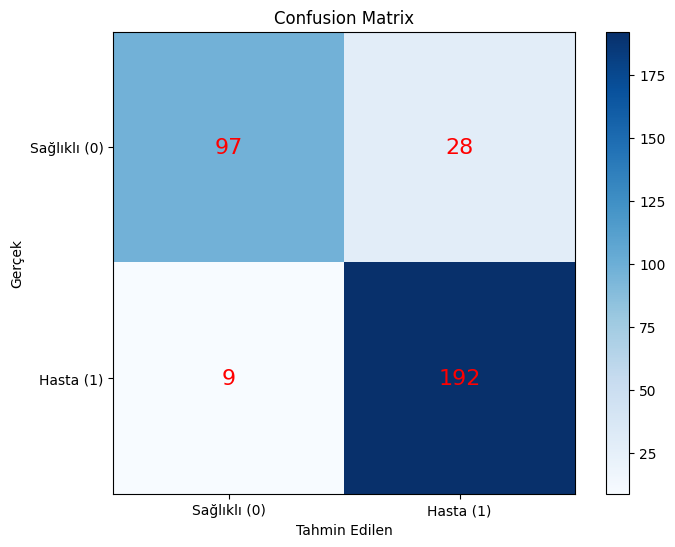

In [14]:
# Karışıklık matrisi
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.xticks([0, 1], ['Sağlıklı (0)', 'Hasta (1)'])
plt.yticks([0, 1], ['Sağlıklı (0)', 'Hasta (1)'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red', fontsize=16)

plt.colorbar()
plt.show()

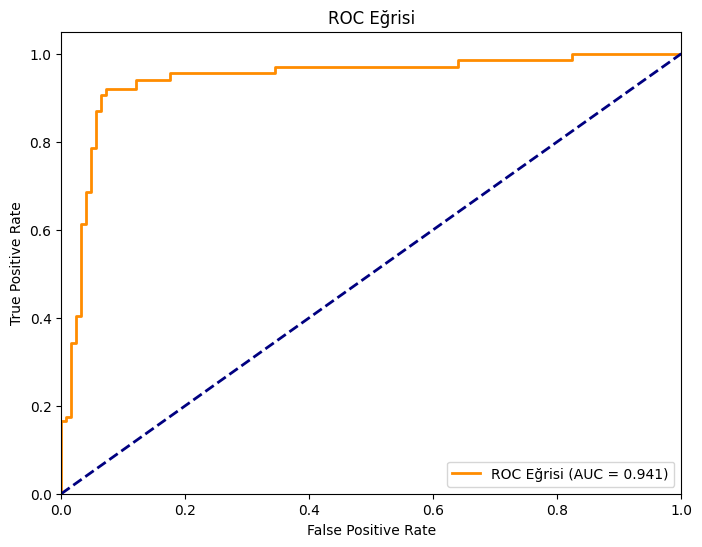

In [15]:
# ROC Eğrisi
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Eğrisi (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

In [16]:
# Öznitelik önemlerini görselleştir (Random Forest ile)
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

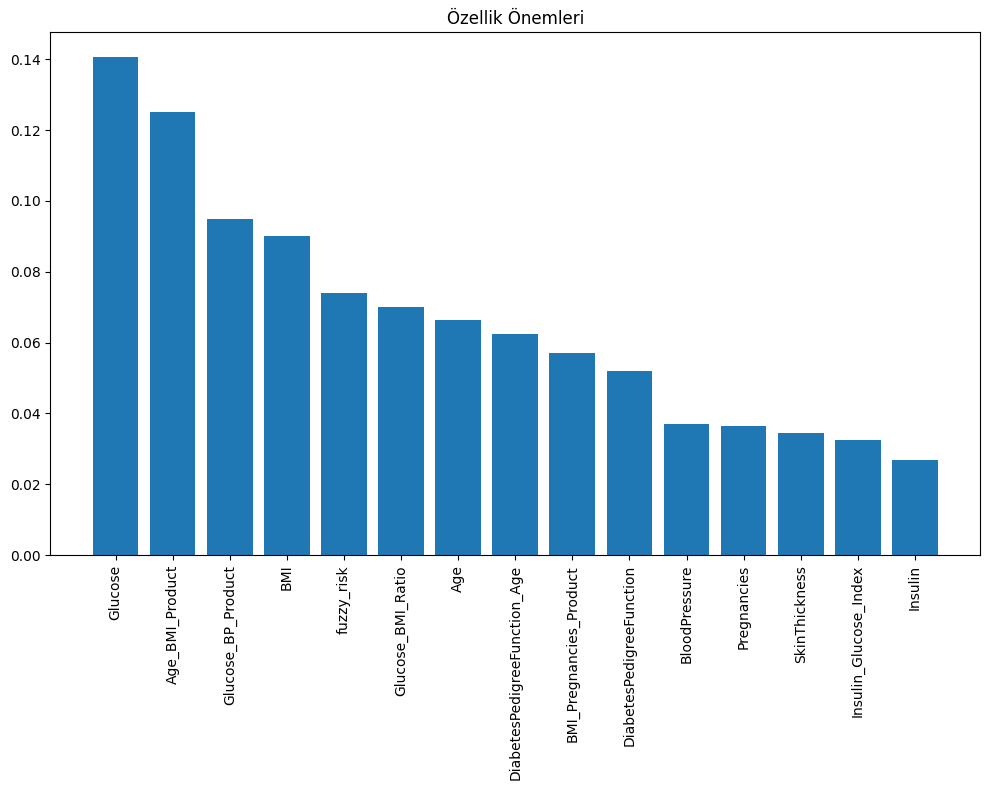

In [17]:
# Özellik önemlerini görselleştir
plt.figure(figsize=(10, 8))
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('Özellik Önemleri')
plt.bar(range(X_train_scaled.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train_scaled.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

Bu kod, modelin **5-katlı çapraz doğrulama** ile performansını değerlendirip, ardından **test seti üzerinde tahmin** yaparak sonuçları raporluyor. Ayrıca, **karışıklık matrisi**, **ROC eğrisi** ve **özelliklerin önemi** gibi görselleştirmeler de içeriyor. Şimdi, her kısmı detaylı bir şekilde açıklayalım:

### 1. **5-Katlı Çapraz Doğrulama**
```python
for train_idx, val_idx in cv.split(X_train_scaled, y_train):
    # Eğitim ve doğrulama setlerini ayır
    X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Modeli eğit
    ensemble.fit(X_cv_train, y_cv_train)
    
    # Doğrulama setinde tahmin yap
    y_cv_pred = ensemble.predict(X_cv_val)
    
    # Doğruluğu hesapla
    accuracy = accuracy_score(y_cv_val, y_cv_pred)
    cv_scores.append(accuracy)

print(f"5-katlı çapraz doğrulama skoru: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
```

- **Çapraz doğrulama (CV)**, modelin genellenebilirliğini değerlendirmek için kullanılır. Burada 5-katlı çapraz doğrulama yapılmaktadır:
  - **`cv.split(X_train_scaled, y_train)`**: Eğitim verisini 5 katmana böler. Her bir katman sırasıyla doğrulama seti olarak kullanılır.
  - **Modelin eğitilmesi (`ensemble.fit`)** ve doğrulama setinde tahmin yapması (`ensemble.predict`).
  - **`accuracy_score(y_cv_val, y_cv_pred)`**: Her katmanda doğruluk skoru hesaplanır ve **cv_scores** listesine eklenir.
  - Son olarak, **ortalama doğruluk** ve **standart sapma** hesaplanır.

### 2. **Final Modeli ve Test Seti Üzerinde Tahmin**
```python
# Final modeli tüm eğitim verisi üzerinde eğit
ensemble.fit(X_train_scaled, y_train)

# Test seti üzerinde tahmin yap
y_pred = ensemble.predict(X_test_scaled)
y_pred_proba = ensemble.predict_proba(X_test_scaled)[:, 1]
```

- **Modeli tüm eğitim verisi ile eğitme**: `ensemble.fit(X_train_scaled, y_train)` ile, en son model tüm eğitim verisiyle yeniden eğitilir.
- **Test verisi üzerinde tahmin yapma**:
  - **`y_pred = ensemble.predict(X_test_scaled)`**: Test setindeki sınıflar tahmin edilir.
  - **`y_pred_proba = ensemble.predict_proba(X_test_scaled)[:, 1]`**: Ayrıca, her sınıfın olasılıkları tahmin edilir (özellikle 1. sınıf için, çünkü ikili sınıflandırma yapılıyor).

### 3. **Sonuçların Değerlendirilmesi**
#### Doğruluk ve Sınıflandırma Raporu
```python
# Sonuçları değerlendir
accuracy = accuracy_score(y_test, y_pred)
print(f"Test seti doğruluğu: {accuracy:.4f}")
print("\nSınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred))
```
- **`accuracy_score(y_test, y_pred)`**: Test seti üzerinde modelin doğruluğu hesaplanır.
- **`classification_report(y_test, y_pred)`**: Modelin doğruluğunun yanı sıra, **precision**, **recall**, **f1-score** gibi daha ayrıntılı metriklerin raporlanmasını sağlar.

#### Karışıklık Matrisi Görselleştirmesi
```python
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.xticks([0, 1], ['Sağlıklı (0)', 'Hasta (1)'])
plt.yticks([0, 1], ['Sağlıklı (0)', 'Hasta (1)'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red', fontsize=16)

plt.colorbar()
plt.show()
```

- **Karışıklık matrisi**: Modelin doğru ve yanlış tahminlerini görselleştiren bir **confusion matrix** oluşturulur.
  - **`cm[i, j]`**: Gerçek etiketler ile tahmin edilen etiketler arasındaki ilişkileri temsil eder.
  - **Görselleştirme**: Matris, `imshow` ile renkli bir şekilde görselleştirilir. **Kırmızı** renkli sayılar, her hücredeki değeri belirtir.

#### ROC Eğrisi
```python
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Eğrisi (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()
```

- **ROC eğrisi**: **Receiver Operating Characteristic (ROC)** eğrisini çizer. Bu eğri, **True Positive Rate (TPR)** ve **False Positive Rate (FPR)** değerleri arasında gösterilir.
- **AUC (Area Under the Curve)**: Bu eğrinin altındaki alan, modelin genel başarısını özetler. AUC değeri 1'e yaklaştıkça modelin başarısı artar.

### 4. **Özellik Önemlerinin Görselleştirilmesi**
```python
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train_scaled, y_train)

plt.figure(figsize=(10, 8))
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('Özellik Önemleri')
plt.bar(range(X_train_scaled.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train_scaled.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()
```

- **Özelliklerin önemi**: `RandomForestClassifier` kullanarak her özelliğin modelin kararına katkısını ölçeriz.
  - **`importances = rf_model.feature_importances_`**: Model, her özelliğin model kararına olan katkısını hesaplar.
  - **`np.argsort(importances)`**: Bu, özellikleri önem sırasına göre sıralar.
  - **Bar grafiği**: Özelliklerin önemlerini görselleştiren bir bar grafiği oluşturulur. Bu, hangi özelliklerin modelin tahminine en fazla katkı sağladığını gösterir.

### Özet:
- **5-Katlı Çapraz Doğrulama**: Modelin genel performansını daha sağlam bir şekilde değerlendirir.
- **Test Seti Üzerinde Performans**: Son modelin test verisi üzerindeki doğruluğu, karışıklık matrisi ve sınıflandırma raporu ile değerlendirilir.
- **ROC Eğrisi**: Modelin sınıflandırma başarısını görsel olarak sunar.
- **Özellik Önemleri**: Hangi özelliklerin model için daha önemli olduğunu görselleştirir.

In [18]:
# Tahmin eşiğini optimize ederek performansı artır
# Farklı tahmin eşiklerini dene
thresholds = np.arange(0.3, 0.8, 0.05)
accuracies = []

for threshold in thresholds:
    y_pred_optimized = (y_pred_proba >= threshold).astype(int)
    accuracies.append(accuracy_score(y_test, y_pred_optimized))

# En iyi eşiği bul
best_threshold_idx = np.argmax(accuracies)
best_threshold = thresholds[best_threshold_idx]
best_accuracy = accuracies[best_threshold_idx]

print(f"En iyi eşik: {best_threshold:.2f}, Doğruluk: {best_accuracy:.4f}")

# En iyi eşik ile final tahminleri oluştur
y_pred_best = (y_pred_proba >= best_threshold).astype(int)
print("\nOptimize Edilmiş Eşik ile Sınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred_best))

En iyi eşik: 0.75, Doğruluk: 0.9172

Optimize Edilmiş Eşik ile Sınıflandırma Raporu:

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       125
           1       0.93      0.94      0.93       201

    accuracy                           0.92       326
   macro avg       0.91      0.91      0.91       326
weighted avg       0.92      0.92      0.92       326




Örnek Vaka Analizi (Index: 0):
Glukoz: 123.0
BMI: 32.0
Yaş: 34.0
Kan Basıncı: 80.0
Pedigree Fonksiyonu: 0.443
Bulanık Risk Skoru: 70.2
Gerçek Etiket: Sağlıklı
Tahmin Edilen Etiket: Sağlıklı
Diyabet Olasılığı: 0.456


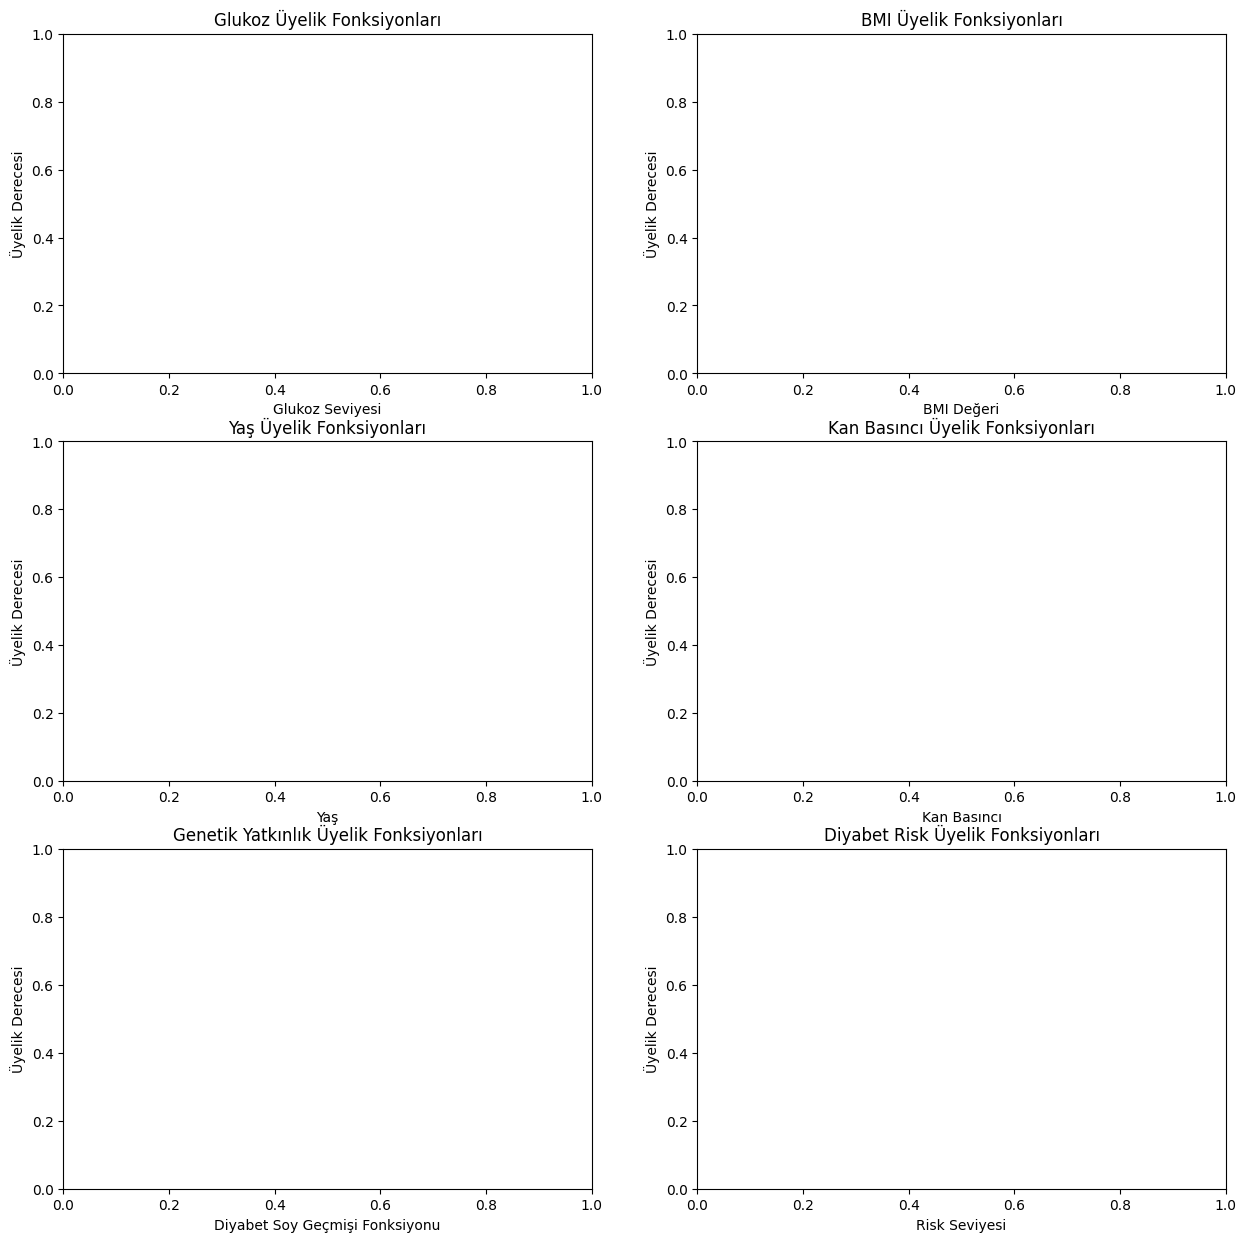

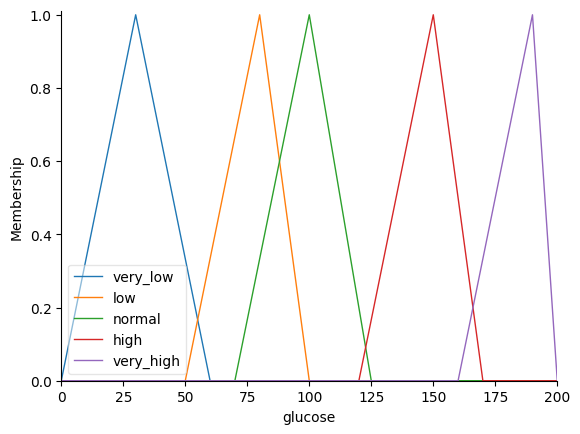

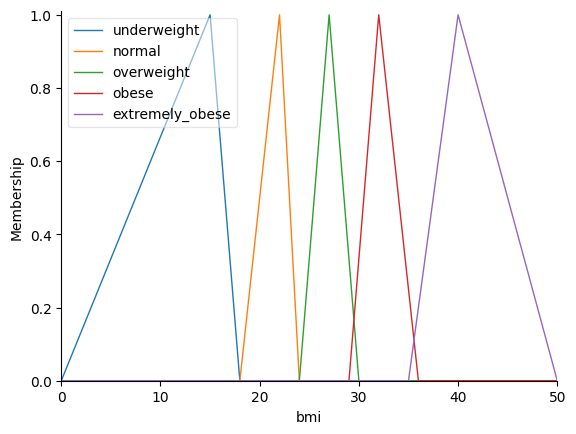

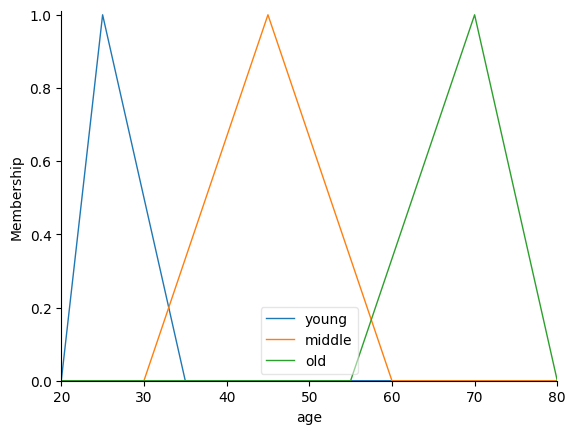

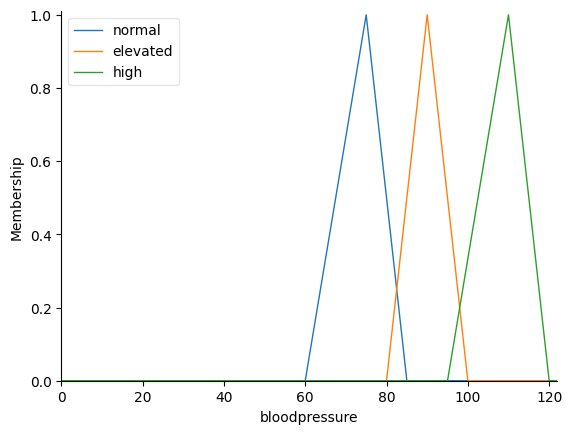

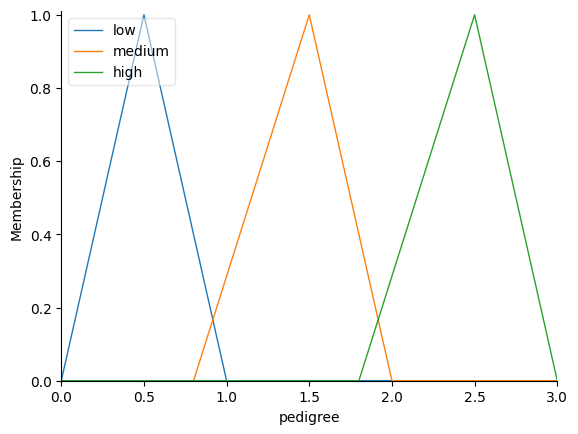

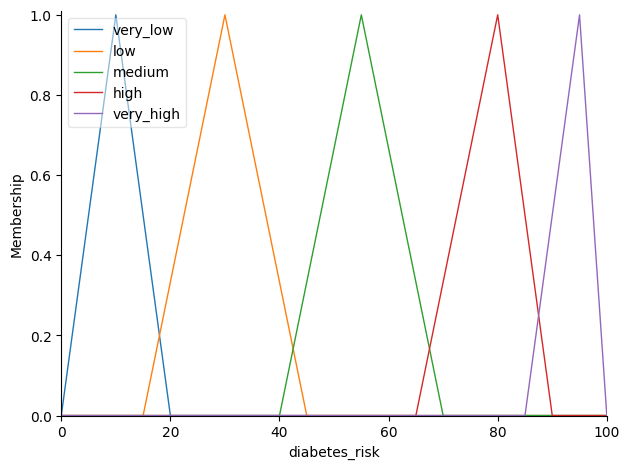

In [19]:
# Önemli özellikleri görselleştir
# Örnek bir vakanın risk değerlendirmesi
example_idx = 0  # İlk test örneği
example_data = X_test.iloc[example_idx]
example_risk = fuzzy_risks_test[example_idx][0]
example_true_label = y_test.iloc[example_idx]
example_pred_label = y_pred[example_idx]

print(f"\nÖrnek Vaka Analizi (Index: {example_idx}):")
print(f"Glukoz: {example_data['Glucose']:.1f}")
print(f"BMI: {example_data['BMI']:.1f}")
print(f"Yaş: {example_data['Age']:.1f}")
print(f"Kan Basıncı: {example_data['BloodPressure']:.1f}")
print(f"Pedigree Fonksiyonu: {example_data['DiabetesPedigreeFunction']:.3f}")
print(f"Bulanık Risk Skoru: {example_risk:.1f}")
print(f"Gerçek Etiket: {'Hasta' if example_true_label == 1 else 'Sağlıklı'}")
print(f"Tahmin Edilen Etiket: {'Hasta' if example_pred_label == 1 else 'Sağlıklı'}")
print(f"Diyabet Olasılığı: {y_pred_proba[example_idx]:.3f}")

# Fuzzy sistemin üyelik fonksiyonlarını görselleştir
# Fuzzy sistemin üyelik fonksiyonlarını görselleştir
rules, glucose, bmi, age, bloodpressure, pedigree, diabetes_risk = create_fuzzy_system()

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# 1. grafik
glucose.view(ax=axes[0, 0])
axes[0, 0].set_title('Glukoz Üyelik Fonksiyonları')
axes[0, 0].set_xlabel('Glukoz Seviyesi')
axes[0, 0].set_ylabel('Üyelik Derecesi')

# 2. grafik
bmi.view(ax=axes[0, 1])
axes[0, 1].set_title('BMI Üyelik Fonksiyonları')
axes[0, 1].set_xlabel('BMI Değeri')
axes[0, 1].set_ylabel('Üyelik Derecesi')

# 3. grafik
age.view(ax=axes[1, 0])
axes[1, 0].set_title('Yaş Üyelik Fonksiyonları')
axes[1, 0].set_xlabel('Yaş')
axes[1, 0].set_ylabel('Üyelik Derecesi')

# 4. grafik
bloodpressure.view(ax=axes[1, 1])
axes[1, 1].set_title('Kan Basıncı Üyelik Fonksiyonları')
axes[1, 1].set_xlabel('Kan Basıncı')
axes[1, 1].set_ylabel('Üyelik Derecesi')

# 5. grafik
pedigree.view(ax=axes[2, 0])
axes[2, 0].set_title('Genetik Yatkınlık Üyelik Fonksiyonları')
axes[2, 0].set_xlabel('Diyabet Soy Geçmişi Fonksiyonu')
axes[2, 0].set_ylabel('Üyelik Derecesi')

# 6. grafik
diabetes_risk.view(ax=axes[2, 1])
axes[2, 1].set_title('Diyabet Risk Üyelik Fonksiyonları')
axes[2, 1].set_xlabel('Risk Seviyesi')
axes[2, 1].set_ylabel('Üyelik Derecesi')

plt.tight_layout()
plt.show()

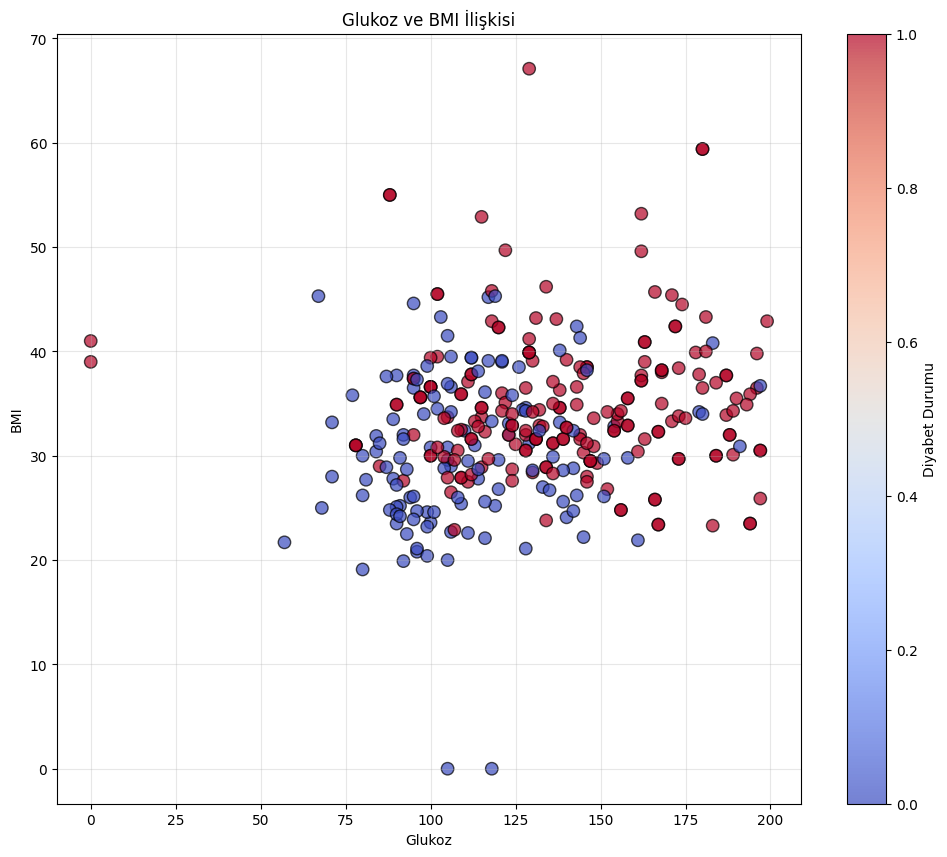

In [20]:
# Özellik çiftlerinin ilişkisini görselleştir (renkler gerçek sınıfı gösterir)
plt.figure(figsize=(12, 10))
plt.scatter(X_test['Glucose'], X_test['BMI'], c=y_test, cmap='coolwarm', 
            edgecolor='k', s=80, alpha=0.7)
plt.colorbar(label='Diyabet Durumu')
plt.title('Glukoz ve BMI İlişkisi')
plt.xlabel('Glukoz')
plt.ylabel('BMI')
plt.grid(True, alpha=0.3)
plt.show()


Hata Yapılan Örneklerin Analizi (Toplam 37 hata):
Glucose - Ortalama: 127.14, Min: 78.00, Max: 197.00
BMI - Ortalama: 34.47, Min: 21.90, Max: 45.30
Age - Ortalama: 38.78, Min: 22.00, Max: 65.00
BloodPressure - Ortalama: 73.76, Min: 0.00, Max: 95.00
DiabetesPedigreeFunction - Ortalama: 0.46, Min: 0.14, Max: 2.33


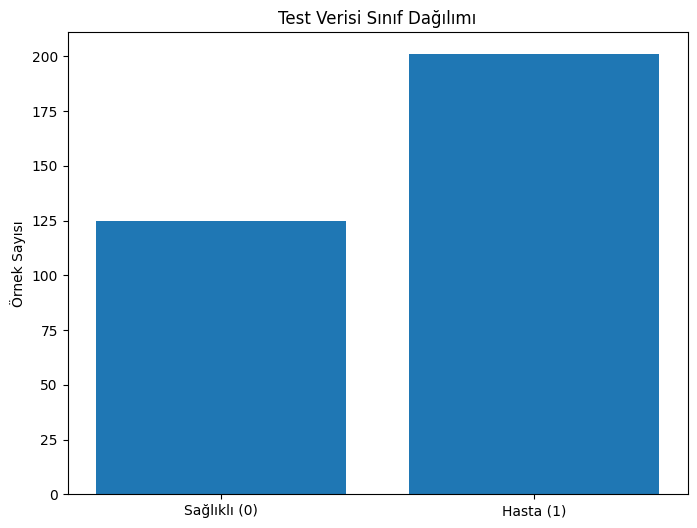

In [21]:
# Tahmin hataları analizi - hangi durumlarda model hata yapıyor?
errors = y_test != y_pred
X_errors = X_test[errors]
y_errors = y_test[errors]

print(f"\nHata Yapılan Örneklerin Analizi (Toplam {np.sum(errors)} hata):")
for feature in ['Glucose', 'BMI', 'Age', 'BloodPressure', 'DiabetesPedigreeFunction']:
    print(f"{feature} - Ortalama: {X_errors[feature].mean():.2f}, Min: {X_errors[feature].min():.2f}, Max: {X_errors[feature].max():.2f}")

# Sınıflar arası dengesizliği görselleştir
plt.figure(figsize=(8, 6))
plt.bar(['Sağlıklı (0)', 'Hasta (1)'], [np.sum(y_test == 0), np.sum(y_test == 1)])
plt.title('Test Verisi Sınıf Dağılımı')
plt.ylabel('Örnek Sayısı')
plt.show()

In [22]:
# Final model performansı özeti
print("\nFinal Model Performans Özeti:")
print(f"Doğruluk: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Optimum Eşik ile Doğruluk: {best_accuracy:.4f}")


Final Model Performans Özeti:
Doğruluk: 0.8865
ROC AUC: 0.9413
Optimum Eşik ile Doğruluk: 0.9172


Tabii, burada çeşitli adımlar yer alıyor. Kodun her bölümünü açıklayarak ilerleyelim:

### 1. **Tahmin Eşiğini Optimize Etme**
   - **Farklı eşik değerlerini deneme:** Bu adımda, modelin sınıflandırma kararlarını belirlemek için kullanılan eşik değeri optimize ediliyor. Başlangıçta, modelin doğruluk skoru (accuracy), varsayılan eşik olan 0.5'e dayanarak hesaplanıyor. Ancak eşik değeri değiştirmek, modelin performansını iyileştirebilir.
   
   - **Threshold Loop:** Eşik değerleri `np.arange(0.3, 0.8, 0.05)` arasında değiştiriliyor. Bu eşikler, modelin tahminini hangi değere göre sınıflandıracağını belirler. Örneğin, 0.4 eşik değeriyle, modelin tahminini 0.4 veya daha yüksek bir olasılıkla `1` (hasta) olarak sınıflandırırsınız.

   - **En iyi eşik değeri bulma:** Tüm eşik değerleri için doğruluk hesaplanır ve en iyi doğruluk sağlayan eşik değeri seçilir.

### 2. **Optimum Eşik ile Final Tahminleri**
   - **En iyi eşik ile final tahminleri:** En iyi eşik bulunduğunda, tahminler bu eşikle güncellenir ve `classification_report` fonksiyonu ile optimize edilmiş modelin performansı değerlendirilir. Bu rapor, doğruluk, precision, recall, f1 skoru gibi metrikleri içerir.

### 3. **Fuzzy Sistem ve Üyelik Fonksiyonları**
   - **Fuzzy sistemin üyelik fonksiyonlarını görselleştirme:** Burada, diyabet riskini tahmin etmek için kullanılan fuzzy mantık üyelik fonksiyonları görselleştiriliyor. Fuzzy sistemde, her bir özellik (glukoz, BMI, yaş, kan basıncı vb.) için bir üyelik fonksiyonu vardır. Bu fonksiyonlar, özelliklerin değerleri ile belirli üyelik derecelerini ilişkilendirir.

   - **Üyelik fonksiyonları:** Örneğin, `Glucose`, `BMI`, `Age` gibi özelliklerin üyelik fonksiyonları, o özelliğin diyabet riskine ne kadar katkı sağladığını gösterir. Grafiklerde bu fonksiyonlar, değerlerin üyelik derecelerine karşılık gelen eğriler olarak gösterilir.

### 4. **Özelliklerin İlişkisi ve Visualizations**
   - **Özellik çiftlerinin ilişkisini görselleştirme:** Burada, `Glucose` ve `BMI` gibi özelliklerin test verisindeki ilişkisi görselleştirilir. Özellikler arasındaki korelasyon ve modelin sınıf tahminlerine (hasta/sağlıklı) olan etkisini görselleştiririz.
   
   - **Renklerle sınıf gösterimi:** Scatter plot kullanılarak bu ilişkiler görselleştirilir. Renkler, veri noktalarının sağlıklı (`0`) veya hasta (`1`) olma durumlarını gösterir.

### 5. **Tahmin Hataları Analizi**
   - **Tahmin hatalarının analizi:** Modelin yaptığı hataları analiz ederiz. `errors` dizisi, tahminlerin yanlış olduğu yerleri belirler. Bu yanlış tahminlerin hangi özelliklerde yoğunlaştığını inceleyerek modelin hangi durumlarda hata yaptığını anlamaya çalışırız.

### 6. **Sınıf Dengesizliği Görselleştirme**
   - **Sınıf dengesizliği:** Test verisindeki sınıfların (sağlıklı ve hasta) dağılımı görselleştirilir. Bu, sınıflar arasındaki dengesizliği (örneğin, hasta sınıfının daha fazla olması) göstermek için kullanılır. Eğer veri setinde ciddi bir dengesizlik varsa, modelin performansını iyileştirmek için bazı teknikler uygulanabilir (örneğin, SMOTE).

### 7. **Final Model Performansı Özeti**
   - **Final modelin doğruluğu:** Modelin final performansı özetlenir. Bu, doğruluk, ROC AUC gibi metrikleri içerir. Ayrıca, en iyi eşik ile yapılan tahminlerin doğruluğu da gösterilir.

**Özetle:** 
- Kod, modelin doğruluk performansını optimize etmek için tahmin eşiklerini değiştirmeyi içerir.
- Modelin sonuçlarını, görselleştirmeler ve analizlerle destekler.
- Bu süreçler, modelin doğruluğunu, özelliklerin etkisini ve tahmin hatalarını daha iyi anlamanızı sağlar.

Umarım açıklamalar yardımcı olmuştur! Başka bir şey sormak isterseniz, yardımcı olmaktan memnuniyet duyarım.